# Final Project

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.

## Your assignment

Build a Multi-Layer Perceptron and train it to classify masses as benign or malignant based on its features.

The data needs to be cleaned; many rows contain missing data, and there may be erroneous data identifiable as outliers as well.

Remember to normalize your data first! And experiment with different topologies, optimizers, and hyperparameters.

I was able to achieve over 80% accuracy - can you beat that?


## Let's begin: prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe (hint: use read_csv) and take a look at it.

In [11]:
import pandas as pd

r_cols = ['bi_rads', 'age', 'shape', 'margin', 'density', 'severity']

df = pd.read_csv("mammographic_masses.data.txt",names=r_cols, na_values='?')

Make sure you use the optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x63da3af50>,
      dtype=object)

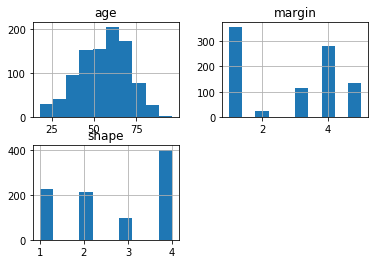

In [12]:
df[['age', 'shape', 'margin']].hist()

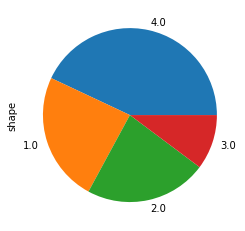

In [13]:
import matplotlib.pyplot as plt


df['shape'].value_counts().plot(kind="pie")

Evaluate whether the data needs cleaning; your model is only as good as the data it's given. Hint: use describe() on the dataframe.

In [14]:
df.describe()

,bi_rads,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. Does there appear to be any sort of correlation to what sort of data has missing fields? If there were, we'd have to try and go back and fill that data in.

In [15]:
print(df.loc[(df['age'].isnull()) |
              (df['shape'].isnull()) |
              (df['margin'].isnull()) |
              (df['density'].isnull())])

bi_rads   age  shape  margin  density  severity
1        4.0  43.0    1.0     1.0      NaN         1
4        5.0  74.0    1.0     5.0      NaN         1
5        4.0  65.0    1.0     NaN      3.0         0
6        4.0  70.0    NaN     NaN      3.0         0
7        5.0  42.0    1.0     NaN      3.0         0
..       ...   ...    ...     ...      ...       ...
778      4.0  60.0    NaN     4.0      3.0         0
819      4.0  35.0    3.0     NaN      2.0         0
824      6.0  40.0    NaN     3.0      4.0         1
884      5.0   NaN    4.0     4.0      3.0         1
923      5.0   NaN    4.0     3.0      3.0         1

[130 rows x 6 columns]


If the missing data seems randomly distributed, go ahead and drop rows with missing data. Hint: use dropna().

In [16]:
df.dropna(inplace=True)
df.reset_index(drop=True)
df = df.drop(columns=['index', 'bi_rads'], errors='ignore')
for i, column in enumerate(df.columns):
    print(column, df[column].unique())

age [67. 58. 28. 57. 76. 42. 36. 60. 54. 52. 59. 56. 75. 45. 55. 46. 39. 81.
 78. 50. 62. 64. 74. 80. 49. 73. 68. 66. 25. 44. 33. 71. 84. 51. 24. 40.
 86. 65. 53. 47. 63. 41. 34. 23. 87. 21. 19. 35. 37. 79. 85. 48. 72. 43.
 69. 38. 32. 70. 77. 61. 27. 83. 88. 31. 29. 18. 26. 93. 30. 22. 96. 20.]
shape [3. 4. 1. 2.]
margin [5. 1. 4. 3. 2.]
density [3. 2. 1. 4.]
severity [1 0]


Next you'll need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. Create an array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). You'll also need an array of the feature name labels.

In [17]:
import numpy as np

data = df[['age', 'shape', 'margin', 'density']].values
target = df.severity.values
column_names = ['age', 'shape', 'margin', 'density']


Some of our models require the input data to be normalized, so go ahead and normalize the attribute data. Hint: use preprocessing.StandardScaler().

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

normalized_data = scaler.fit_transform(data)
normalized_data.shape

(830, 4)

## Now build your neural network.

Now set up an actual MLP model using Keras:

In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
  model = Sequential([
    Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='sigmoid')])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

clf = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
cross_val_score(clf, normalized_data, target,  cv=10).mean()

0.8024096369743348